In [1]:
!pip install python-snappy
!pip install fastparquet
!pip install tensorflow
!pip install keras

     |████████████████████████████████| 54 kB 348 kB/s  eta 0:00:01
     |████████████████████████████████| 120 kB 26.7 MB/s eta 0:00:01
     |████████████████████████████████| 59 kB 9.1 MB/s  eta 0:00:01
  Created wheel for fastparquet: filename=fastparquet-0.5.0-cp36-cp36m-linux_x86_64.whl size=208386 sha256=85abb39bc08af37fc778b9ff78383a64850a83ee9b921d20a4a21cf4c3e82280
  Stored in directory: /home/ec2-user/.cache/pip/wheels/95/05/79/06390130876ed494128b54550135880b7da56eb92862cf3e7e
  Created wheel for thrift: filename=thrift-0.13.0-cp36-cp36m-linux_x86_64.whl size=389598 sha256=f94a290303d603b514bd0c02d79999f0ab5b26f2f550a58f09fdc334f716e64b
  Stored in directory: /home/ec2-user/.cache/pip/wheels/e0/38/fc/472fe18756b177b42096961f8bd3ff2dc5c5620ac399fce52d
Successfully built fastparquet thrift
     |████████████████████████████████| 394.3 MB 6.2 kB/s  eta 0:00:01     |█████████████████████▉          | 268.4 MB 36.3 MB/s eta 0:00:04     |███████████████████████▎        | 287.3 MB 3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas
import math
import time

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import ParquetReader as pq

# Imputation Validation

Author: Kyung Myung (Andy) Ko<br>

Single channel's range of values (500) will be imputed at a time.<br><br>
Training data must not include any null values, and validation set was chosen to be the next 500 rows of data after the tranining data

Used: Asset 1, March file

Example:  
1. Low-variance<br>
``
Range:   [100,000 : 130,000] 
Channel:  Comp08_FluidD_SensorB  (CH=43)
Missing:  START=130,000  END=130,504
``<br>
2. High-variance<br>
``
Range:   [100,000 : 130,500] 
Channel:  Comp08_FluidD_SensorB  (CH=43)
Missing:  START=130,500  END=131,004
``<br><br>

Reason for the extra 4 rows in END: will be needed to generate a 3d numpy array shape in preprocessing step

Reference : https://github.com/IvanBongiorni/GAN-RNN_Timeseries-imputation

## Data selection
Using a multivariate time-series data with 15 features, ``Channel #43-58``

In [175]:
# fix random seed for reproducibility
np.random.seed(7)

file_path = pq.get_filenames(asset=1)[2]
full_df = pq.read_parquet_file(file_path)
full_df = full_df.drop(columns='serial_number')

# channel number and start/end of mising data
CH = 43

# Target channel for imputation (in df_missing_filled)
impute_CH = 0

### Determine which region to impute ###

# Low-variance region (gan2)
RANGE_START = 100000
RANGE_END = 130000
START = 130000
# the last 4 will be removed while converting to 3d numpy array
END = 130504

# High-variance region (gan1)
# RANGE_START = 100000
# RANGE_END = 130500
# START = 130500
# # the last 4 will be removed while converting to 3d numpy array
# END = 131004

##########################################



# Input dim for generator
time_step = 4
num_features = 15

# number of values imputing (range of imputing region)
num_imputes = END-START-time_step

# Starting index for missing data
tSTART = RANGE_END - RANGE_START


# Dataset with no null values
df_real = full_df[full_df.columns[CH:CH+num_features]][RANGE_START:END]


# create amputed dataset (30504, 15)
df_missing = df_real.copy()

# removing the the 504 after the training data
df_missing[df_missing.columns[impute_CH]][tSTART:] = np.nan
print("\nShape of dataframe with missing values: {}".format(df_missing.shape))
print("Number of nulls: {}\n".format(df_missing[df_missing.columns[impute_CH]][tSTART:].isna().sum()))



# whole range of sub-dataset of march from channel "Comp08_FluidD_SensorB"
print("Shape of dataframe with no null values: {}".format(df_real.shape))
print("Number of nulls: {}".format(df_real[df_real.columns[impute_CH]].isna().sum()))

reading: s3://cds-purd-input/ABC00123/ABC00123-2020-3.parquet  DONE

Shape of dataframe with missing values: (30504, 15)
Number of nulls: 504

Shape of dataframe with no null values: (30504, 15)
Number of nulls: 0


### Target range of missing values
Blue plot shows the target range to impute

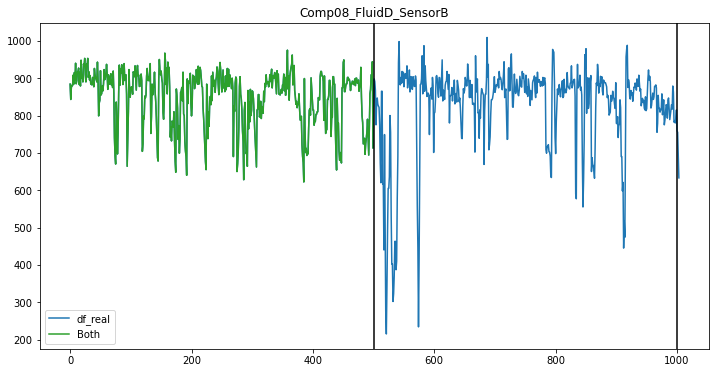

In [176]:
# What we want to impute


p = pd.DataFrame(
    {'df_real':df_real[df_real.columns[impute_CH]][tSTART-500:].values, 'Both':df_missing[df_missing.columns[impute_CH]][tSTART-500:].values}, index=range(0, 1004)
#     {'df_real':df_real[df_real.columns[impute_CH]][tSTART-500:].values, 'Both':df_missing[df_missing.columns[impute_CH]][tSTART-500:].values}, index=range(0, 2004)
).plot(title='Comp08_FluidD_SensorB', figsize=(12,6), color=('#1f77b4', '#2ca02c'))
p = plt.axvline(x=500, color='black')
# p = plt.axvline(x=1004, color='black')
p = plt.axvline(x=1000, color='black')

### Fill the missing values 
df_missing[low_variance/high_variance] = (500 rows) will be filled with normally distributed values

In [177]:
import helper_functions as hf

df_missing_filled = hf.fill_with_random_norm(df_missing, impute_CH, END-START, tSTART, "median")
print(df_missing_filled.isna().sum())
print(df_missing_filled.shape)

df_missing_filled[[df_missing_filled.columns[impute_CH]]][tSTART:]

Comp08_FluidD_SensorB        0
Comp12_FluidB_SensorB        0
2ndComp10_FluidA_SensorA     0
Comp01_maxdeltaSensorB       0
Comp05_SensorJ - discrete    0
2ndComp10_FluidA_SensorB     0
LocB_Comp11_SensorA          0
LocBLoc2_Comp02_SensorD      0
Comp17_deltaSensorB          0
Comp12_inputSensorD          0
Comp07A_SensorA              0
Comp03B_SensorB              0
Comp16C_FluidB_SensorB       0
Comp09A_SensorD              0
Comp07C_deltaSensorB         0
dtype: int64
(30504, 15)


,Comp08_FluidD_SensorB
event_ts,
2020-03-03 00:18:13,1307.0
2020-03-03 00:18:14,721.0
2020-03-03 00:18:15,857.0
2020-03-03 00:18:16,959.0
2020-03-03 00:18:17,634.0
...,...
2020-03-03 00:26:32,920.0
2020-03-03 00:26:33,1262.0
2020-03-03 00:26:34,338.0


### Filled value vs Original
Target range: 0-500<br>
``504 rows will be reduced to 500 while reshaping to timeseries form``

### Not efficient to use (Don't run this cell)
Choosing a larger region at a time (1000), where there are both high-variance and low variance regions, will make the imputation to be misleading<br>

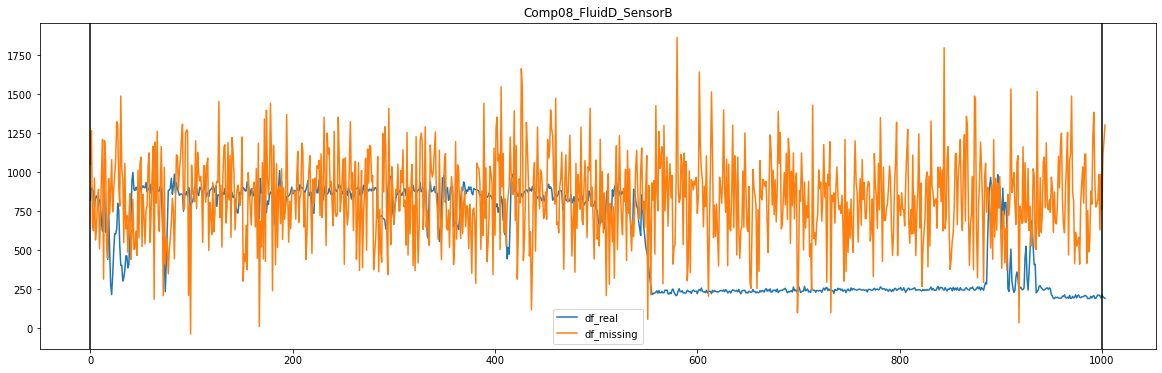

In [40]:
# What we want to impute
p = pd.DataFrame(
    {'df_real':df_real[df_real.columns[impute_CH]][tSTART:].values, 'df_missing':df_missing_filled[df_missing_filled.columns[impute_CH]][tSTART:].values}, index=range(0, 1004)
).plot(title='Comp08_FluidD_SensorB', figsize=(20,6), color=('#1f77b4', '#ff7f0e'))
p = plt.axvline(x=0, color='black')
p = plt.axvline(x=1000, color='black')

### Overview of the target region for imputing

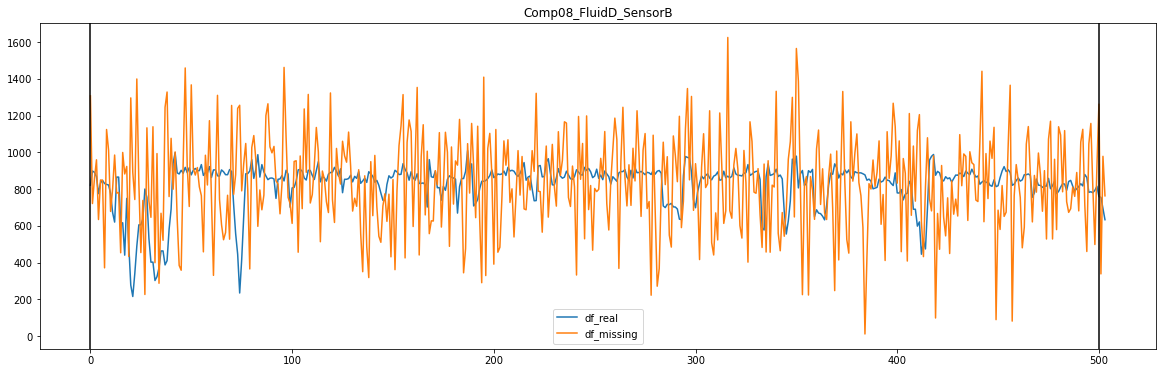

In [178]:
# What we want to impute
p = pd.DataFrame(
    {'df_real':df_real[df_real.columns[impute_CH]][tSTART:].values, 'df_missing':df_missing_filled[df_missing_filled.columns[impute_CH]][tSTART:].values}, index=range(0, 504)
#     {'df_real':df_real[df_real.columns[impute_CH]][tSTART:].values, 'df_missing':df_missing_filled[df_missing_filled.columns[impute_CH]][tSTART:].values}, index=range(0, 1504)
).plot(title='Comp08_FluidD_SensorB', figsize=(20,6), color=('#1f77b4', '#ff7f0e'))
p = plt.axvline(x=0, color='black')
p = plt.axvline(x=500, color='black')
# p = plt.axvline(x=1500, color='black')

## Preprocessing
Transforming df_missing_filled to be used for training

### Normalize and split

In [179]:
scaler = MinMaxScaler()

normalized_filled_data = scaler.fit_transform(df_missing_filled)
    
train_size = int(len(normalized_filled_data) * 0.80)
test_size = len(normalized_filled_data) - train_size

train, test = normalized_filled_data[0:train_size,:], normalized_filled_data[train_size:len(normalized_filled_data),:]
print(train.shape)
print(test.shape)

(24403, 15)
(6101, 15)


### Generate a timeseries form data
Generates a 3d numpy array, will reduce down the number of rows by 4.<br>
``Efficiently used in training step``

In [180]:
print("Train data processing:")
trainX, trainY = hf.form_timeseries(train, time_step, num_features)
print("trainX.shape: {}\ntrainY.shape:{}".format(trainX.shape, trainY.shape))
print("\nTest data processing:")
testX, testY = hf.form_timeseries(test, time_step, num_features)
print("testX.shape: {}\ntestY.shape:{}".format(testX.shape, testY.shape))

Train data processing:
trainX.shape: (24399, 4, 15)
trainY.shape:(24399, 4, 15)

Test data processing:
testX.shape: (6097, 4, 15)
testY.shape:(6097, 4, 15)


## Model Construction
This step shows the details of the model, along with the training method.<br>
There are already saved models ready to use in "/saved_models".<br>
gan_1 = generator1, discriminator1 -> trained with (30000, 15) with 500 values filled between 11800 ~ 12300<br>
gan_2 = generator2, discriminator2 -> trained with (30500, 15) with 500 values filled between 30000 ~ 30500<br>

In [9]:
import model as md
generator, discriminator = md.build_GAN()

Generator: 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 15)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 64)           20480       input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 4, 32)        1472        input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 4, 64)        0           lstm[0][0]                       
_________________________________________________________________________________

### Training GAN
Don't need to train manually, there are trained models below.<br>

Epoch 1/5 - 0/350 - 9.6s 
Generator Loss: 0.45931515097618103 - Discriminator Loss: 1.4081138372421265
Training Loss: 0.42054301500320435 - Validation Loss: 0.4607885777950287

Epoch 1/5 - 50/350 - 9.3s 
Generator Loss: 0.4676647186279297 - Discriminator Loss: 1.4516327381134033
Training Loss: 0.5066288113594055 - Validation Loss: 0.4557360112667084

Epoch 1/5 - 100/350 - 9.2s 
Generator Loss: 0.6900131106376648 - Discriminator Loss: 1.3894376754760742
Training Loss: 0.7004737257957458 - Validation Loss: 0.6095466017723083

Epoch 1/5 - 150/350 - 9.2s 
Generator Loss: 0.6926901340484619 - Discriminator Loss: 1.386751651763916
Training Loss: 0.5021071434020996 - Validation Loss: 0.5852552652359009

Epoch 1/5 - 200/350 - 9.2s 
Generator Loss: 0.6929764151573181 - Discriminator Loss: 1.386465072631836
Training Loss: 0.5792476534843445 - Validation Loss: 0.5838968753814697

Epoch 1/5 - 250/350 - 9.2s 
Generator Loss: 0.6930137872695923 - Discriminator Loss: 1.386427640914917
Training Loss: 

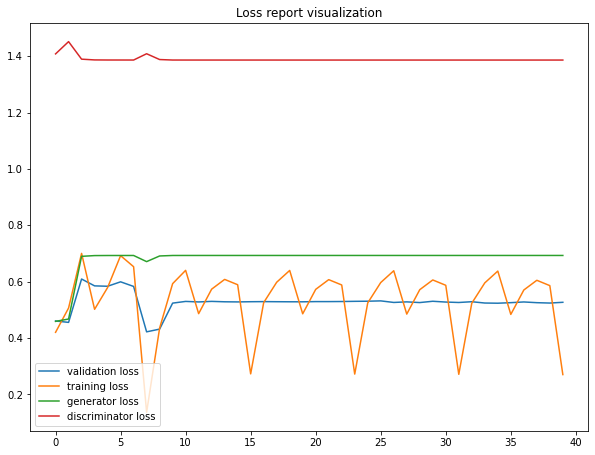

In [10]:
import train_gan as tg

tg.train_gan(generator, discriminator, train, test, 64, 0)

## Generate result
Currently, there are two pairs of generator and discriminators as the saved models. (generator1.h5 & discriminator1.h5) will be more efficient in capturing high-varience regions, while (generator2.h5 & discriminator2.h5) are able to capture more efficiently on low-variance regions.<br><br>

### Using the saved models
gan_2 = generator2.h5, discriminator2.h5 

### Load the models and generate prediction results

In [181]:
generator = tf.keras.models.load_model('saved_models/generator2.h5')
discriminator = tf.keras.models.load_model('saved_models/discriminator2.h5')

In [182]:
normalized_missing_data_filled = scaler.fit_transform(df_missing_filled)
filled_missingX, filled_missingY = hf.form_timeseries(normalized_missing_data_filled, 4, num_features)
print("Time series data shape: {}".format(filled_missingX.shape))

Time series data shape: (30500, 4, 15)


In [183]:
filled_missingPredict = generator.predict(filled_missingX)
filled_predicted_missing_df = hf.get_result_df(filled_missingPredict, filled_missingPredict.shape[2])
filled_predicted_missing_df_reshaped = np.transpose(filled_predicted_missing_df)

filled_missingPredict_channel_reshaped = scaler.inverse_transform(filled_predicted_missing_df_reshaped)
filled_predicted_result = hf.back_to_norm_df(filled_missingPredict_channel_reshaped, 0)
print(filled_predicted_result.shape)
filled_predicted_result

(30500,)


array([5057.1455, 5020.119 , 4838.8394, ..., 5736.976 , 5765.489 ,
       5755.416 ], dtype=float32)

### Comparison over the orginal values

On low-variance region: (30000~30500) (More efficient)

Average: 4841.0
(500,)


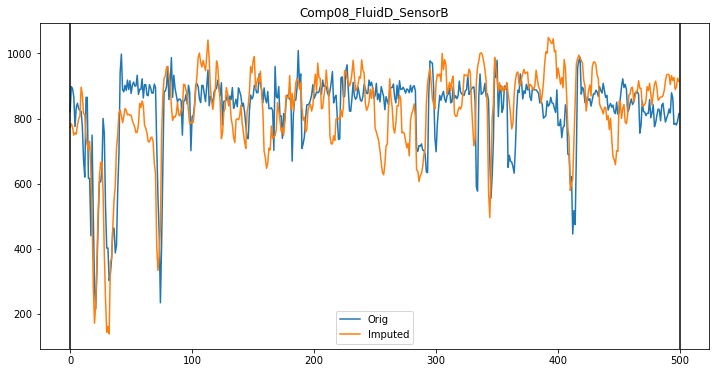

In [184]:
pred_subtracted = hf.scale_down(df_real, filled_predicted_result, tSTART, END-START-time_step)

p = pd.DataFrame(
    {'Orig':df_real[df_real.columns[0]][tSTART:tSTART+num_imputes].values, 'Imputed':pred_subtracted[:]}, index=range(0, num_imputes)
#     {'Orig':df_real[df_real.columns[0]][tSTART:tSTART+1500].values, 'Imputed':pred_subtracted[:]}, index=range(0, 1500)
).plot(title='Comp08_FluidD_SensorB', figsize=(12,6))
p = plt.axvline(x=0, color='black')
p = plt.axvline(x=500, color='black')
# p = plt.axvline(x=1500, color='black')

### Result report

RMSE: 109.78

Bias:  0.55
MAE:   85.22

Norm Bias:  0.067%
Norm MAE:   10.311%


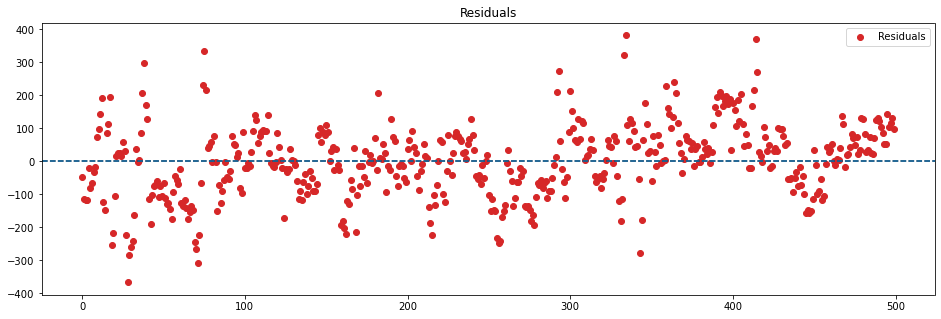

In [185]:
expected = df_real[df_real.columns[impute_CH]][tSTART:tSTART+num_imputes].values
predicted = pred_subtracted[:]

RMSE = math.sqrt(mean_squared_error(expected, predicted))
mae = mean_absolute_error(expected, predicted)
base_mae = mean_absolute_error(expected, np.full(len(expected), expected.mean()))
improvement = 1 - mae/base_mae

resid = pred_subtracted[:] - df_real[df_real.columns[impute_CH]][tSTART:tSTART+num_imputes].values

p = pd.DataFrame({'Residuals':resid}).plot(ls='None', marker='o', figsize=(16,5), color='tab:red', title='Residuals')
p = plt.axhline(y=0, color='black', ls='--')
p = plt.axhline(y=resid.mean(), color='tab:blue', ls='--')


print('RMSE: %.2f' % (RMSE))

print("\nBias:  %.2f" % resid.mean())
print("MAE:   %.2f" % mae)

print("\nNorm Bias:  %.3f%%" % (resid.sum() / expected.sum() * 100))
print("Norm MAE:   %.3f%%" % (np.abs(predicted - expected).sum() / expected.sum() * 100))

On high-variance region (30500~31000) (Poor)

Average: 4524.0
(500,)


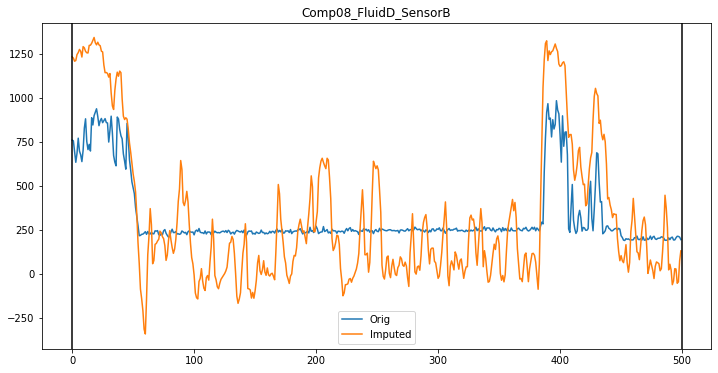

In [173]:
pred_subtracted = hf.scale_down(df_real, filled_predicted_result, tSTART, END-START-time_step)

p = pd.DataFrame(
    {'Orig':df_real[df_real.columns[0]][tSTART:tSTART+num_imputes].values, 'Imputed':pred_subtracted[:]}, index=range(0, num_imputes)
#     {'Orig':df_real[df_real.columns[0]][tSTART:tSTART+1500].values, 'Imputed':pred_subtracted[:]}, index=range(0, 1500)
).plot(title='Comp08_FluidD_SensorB', figsize=(12,6))
p = plt.axvline(x=0, color='black')
p = plt.axvline(x=500, color='black')
# p = plt.axvline(x=1500, color='black')

### Result report

RMSE: 260.45

Bias:  0.60
MAE:   218.75

Norm Bias:  0.187%
Norm MAE:   67.815%


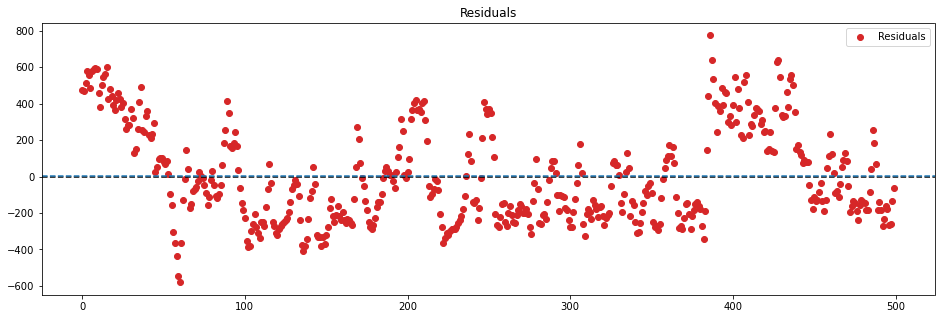

In [174]:
expected = df_real[df_real.columns[impute_CH]][tSTART:tSTART+num_imputes].values
predicted = pred_subtracted[:]

RMSE = math.sqrt(mean_squared_error(expected, predicted))
mae = mean_absolute_error(expected, predicted)
base_mae = mean_absolute_error(expected, np.full(len(expected), expected.mean()))
improvement = 1 - mae/base_mae

resid = pred_subtracted[:] - df_real[df_real.columns[impute_CH]][tSTART:tSTART+num_imputes].values

p = pd.DataFrame({'Residuals':resid}).plot(ls='None', marker='o', figsize=(16,5), color='tab:red', title='Residuals')
p = plt.axhline(y=0, color='black', ls='--')
p = plt.axhline(y=resid.mean(), color='tab:blue', ls='--')


print('RMSE: %.2f' % (RMSE))

print("\nBias:  %.2f" % resid.mean())
print("MAE:   %.2f" % mae)

print("\nNorm Bias:  %.3f%%" % (resid.sum() / expected.sum() * 100))
print("Norm MAE:   %.3f%%" % (np.abs(predicted - expected).sum() / expected.sum() * 100))

### Using the saved models
gan_1 = generator1.h5, discriminator1.h5

### Load the models and generate prediction results

In [186]:
generator = tf.keras.models.load_model('saved_models/generator1.h5')
discriminator = tf.keras.models.load_model('saved_models/discriminator1.h5')

In [187]:
normalized_missing_data_filled = scaler.fit_transform(df_missing_filled)
filled_missingX, filled_missingY = hf.form_timeseries(normalized_missing_data_filled, 4, num_features)
print("Time series data shape: {}".format(filled_missingX.shape))

Time series data shape: (30500, 4, 15)


In [188]:
filled_missingPredict = generator.predict(filled_missingX)
filled_predicted_missing_df = hf.get_result_df(filled_missingPredict, filled_missingPredict.shape[2])
filled_predicted_missing_df_reshaped = np.transpose(filled_predicted_missing_df)

filled_missingPredict_channel_reshaped = scaler.inverse_transform(filled_predicted_missing_df_reshaped)
filled_predicted_result = hf.back_to_norm_df(filled_missingPredict_channel_reshaped, 0)
print(filled_predicted_result.shape)
filled_predicted_result

(30500,)


array([ 11.     ,  11.     ,  11.     , ..., 239.37704, 263.3406 ,
       309.7383 ], dtype=float32)

### Comparison over the orginal values

On low-variance region: (30000~30500) (Poor)

Average: -663.0
(500,)


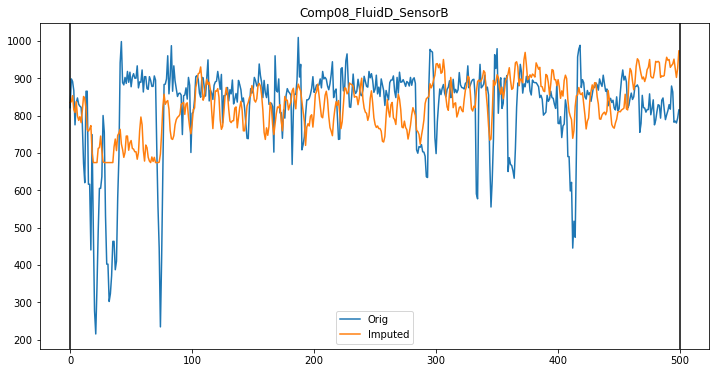

In [189]:
# Rescale the predicted value to match in line
pred_subtracted = hf.scale_down(df_real, filled_predicted_result, tSTART, END-START-time_step)
# What we want to impute
p = pd.DataFrame(
    {'Orig':df_real[df_real.columns[0]][tSTART:tSTART+500].values, 'Imputed':pred_subtracted[:]}, index=range(0, 500)
).plot(title='Comp08_FluidD_SensorB', figsize=(12,6))
p = plt.axvline(x=0, color='black')
p = plt.axvline(x=500, color='black')

### Result report

RMSE: 116.93

Bias:  0.41
MAE:   88.76

Norm Bias:  0.050%
Norm MAE:   10.739%


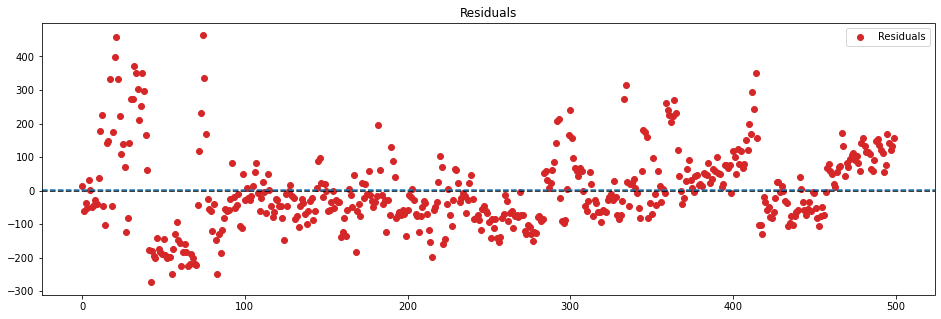

In [190]:
expected = df_real[df_real.columns[impute_CH]][tSTART:tSTART+num_imputes].values
predicted = pred_subtracted[:]

RMSE = math.sqrt(mean_squared_error(expected, predicted))
mae = mean_absolute_error(expected, predicted)
base_mae = mean_absolute_error(expected, np.full(len(expected), expected.mean()))
improvement = 1 - mae/base_mae

resid = pred_subtracted[:] - df_real[df_real.columns[impute_CH]][tSTART:tSTART+num_imputes].values

p = pd.DataFrame({'Residuals':resid}).plot(ls='None', marker='o', figsize=(16,5), color='tab:red', title='Residuals')
p = plt.axhline(y=0, color='black', ls='--')
p = plt.axhline(y=resid.mean(), color='tab:blue', ls='--')


print('RMSE: %.2f' % (RMSE))

print("\nBias:  %.2f" % resid.mean())
print("MAE:   %.2f" % mae)

print("\nNorm Bias:  %.3f%%" % (resid.sum() / expected.sum() * 100))
print("Norm MAE:   %.3f%%" % (np.abs(predicted - expected).sum() / expected.sum() * 100))

On high variance region (30500~31000) (More eficient)

Average: -279.0
(500,)


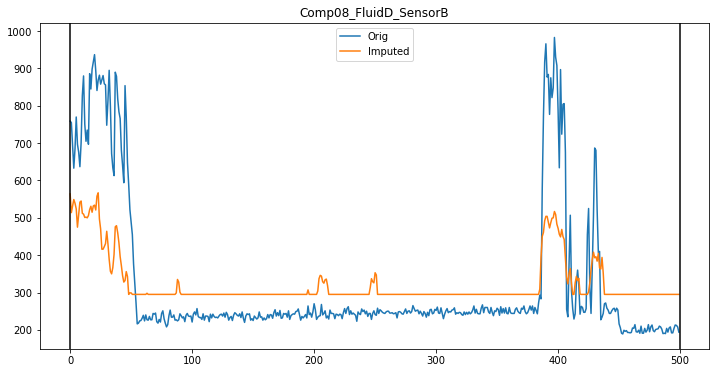

In [167]:
# Rescale the predicted value to match in line
pred_subtracted = hf.scale_down(df_real, filled_predicted_result, tSTART, END-START-time_step)

p = pd.DataFrame(
    {'Orig':df_real[df_real.columns[0]][tSTART:tSTART+num_imputes].values, 'Imputed':pred_subtracted[:]}, index=range(0, num_imputes)
#     {'Orig':df_real[df_real.columns[0]][tSTART:tSTART+1500].values, 'Imputed':pred_subtracted[:]}, index=range(0, 1500)
).plot(title='Comp08_FluidD_SensorB', figsize=(12,6))
p = plt.axvline(x=0, color='black')
p = plt.axvline(x=num_imputes, color='black')
# p = plt.axvline(x=1500, color='black')

### Result report

RMSE: 141.26

Bias:  0.29
MAE:   98.07

Norm Bias:  0.089%
Norm MAE:   30.402%


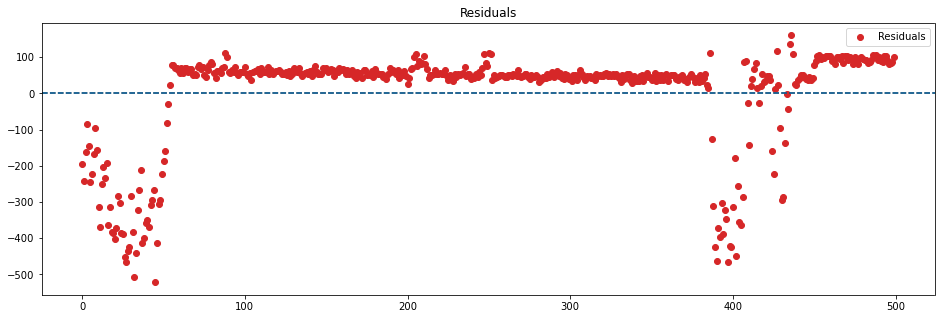

In [169]:
expected = df_real[df_real.columns[impute_CH]][tSTART:tSTART+num_imputes].values
predicted = pred_subtracted[:]

RMSE = math.sqrt(mean_squared_error(expected, predicted))
mae = mean_absolute_error(expected, predicted)
base_mae = mean_absolute_error(expected, np.full(len(expected), expected.mean()))
improvement = 1 - mae/base_mae

resid = pred_subtracted[:] - df_real[df_real.columns[impute_CH]][tSTART:tSTART+num_imputes].values

p = pd.DataFrame({'Residuals':resid}).plot(ls='None', marker='o', figsize=(16,5), color='tab:red', title='Residuals')
p = plt.axhline(y=0, color='black', ls='--')
p = plt.axhline(y=resid.mean(), color='tab:blue', ls='--')


print('RMSE: %.2f' % (RMSE))

print("\nBias:  %.2f" % resid.mean())
print("MAE:   %.2f" % mae)

print("\nNorm Bias:  %.3f%%" % (resid.sum() / expected.sum() * 100))
print("Norm MAE:   %.3f%%" % (np.abs(predicted - expected).sum() / expected.sum() * 100))

## Comparison plots between gan_1 and gan_2
gan_1 = generator1.h5, discriminator1.h5<br>
gan_2 = generator2.h5, discriminator2.h5<br>
(Don't re-run the next cells, will break)

### Low-variance region
Most values that are getting imputed are close to the mean

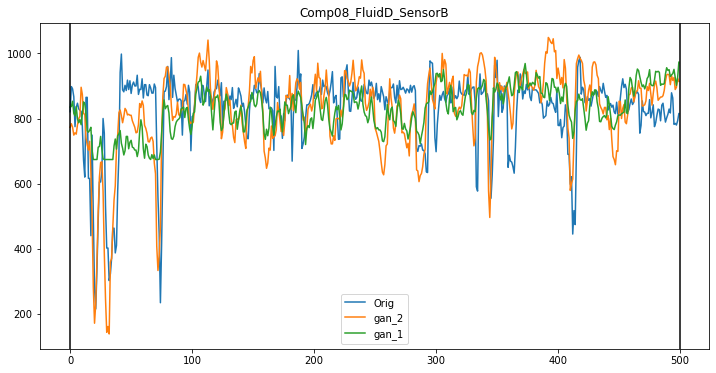

In [30]:
p = pd.DataFrame(
    {'Orig':df_real[df_real.columns[0]][tSTART:tSTART+500].values, 'gan_2':gan_2_result[:],
    'gan_1':gan_1_result[:]}, index=range(0, 500)
).plot(title='Comp08_FluidD_SensorB', figsize=(12,6))
p = plt.axvline(x=0, color='black')
p = plt.axvline(x=500, color='black')

### High-variance region
Most values that are getting imputed are away from the mean

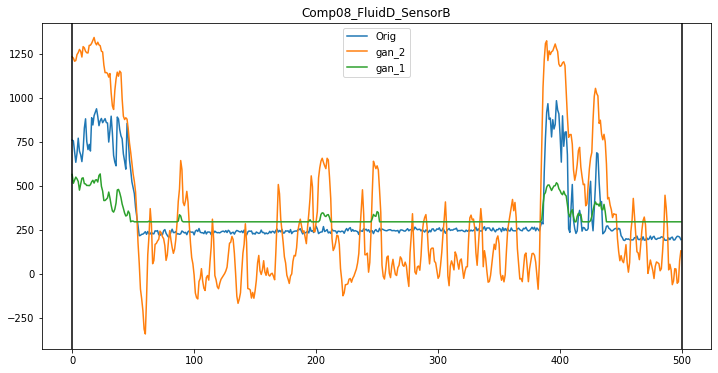

In [122]:
p = pd.DataFrame(
    {'Orig':df_real[df_real.columns[0]][tSTART:tSTART+num_imputes].values, 'gan_2':gan_2[:],
    'gan_1':gan_1[:]}, index=range(0, num_imputes)
).plot(title='Comp08_FluidD_SensorB', figsize=(12,6))
p = plt.axvline(x=0, color='black')
p = plt.axvline(x=num_imputes, color='black')

## Conclusion
Using approximately 30,000 rows * 15 columns of data enabled some level of prediction. However, for more optimization, the following problems needs to be further investigated: how to detect if the imputing region is in low-variance or high-variance, how to select more imputing regions at a time (using mean/med + std normal distribution).